In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances, paired_cosine_distances
from sklearn.neighbors import kneighbors_graph, RadiusNeighborsTransformer
from sklearn.decomposition import PCA
import os, sys
import pickle
from scipy import stats
import random

from scipy.sparse import csr_matrix



In [45]:

max_curves = 4000
attributes = ['0','1','2','3','4','brightness', 'contrast', 'hue']
features = ["Head angle", "Age", "Hair color", "Illumination", "Expression"] + ['Brightness', 'Contrast', 'Hue']


# Precompute necessary quantities
metadata = pd.read_csv("../../data/generated_synthetic/gan_control/df_param_step.csv") 
metadata = metadata.assign(moving_dimension=lambda x: x['moving_dimension'].astype("str")) # Fix problem in metadata
metadatas = {dim: metadata.loc[metadata["moving_dimension"]==dim] for dim in attributes} # Filter the metadas for each attribute
ids_curves = {dim:np.unique(metadatas[dim]["id_curve"].values) for dim in attributes} 
for dim in ids_curves.keys():
    random.shuffle(ids_curves[dim])

# Sample the curves
adfs = {dim: metadatas[dim][metadatas[dim]["id_curve"].isin(ids_curves[dim][:max_curves])].sort_values("id_curve") for dim in attributes}

# Compute the indices of the emebeddings
adfs_0 = {dim: adfs[dim][adfs[dim]["param_step"]==0]["index"].values for dim in attributes}
adfs_1 = {dim: adfs[dim][adfs[dim]["param_step"]==1]["index"].values for dim in attributes}
adfs_2 = {dim: adfs[dim][adfs[dim]["param_step"]==2]["index"].values for dim in attributes}



/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [46]:

# Load embeddings
embeddings = np.load("../../data/generated_synthetic/gan_control/embeddings/vanilla/facenet/20241019_1751_1.npy")

idx_dim = 5
dim = attributes[idx_dim]

embs_pc = embeddings[adfs_1[dim],:] # point cloud

n_points = embs_pc.shape[0]

vf_pc = embeddings[adfs_2[dim],:] - embeddings[adfs_0[dim],:] # vector field (3 point stencil)
vf_pc = (vf_pc.T/np.linalg.norm(vf_pc, axis = 1)).T # normalize vector field

Text(0.5, 1.0, 'Brightness')

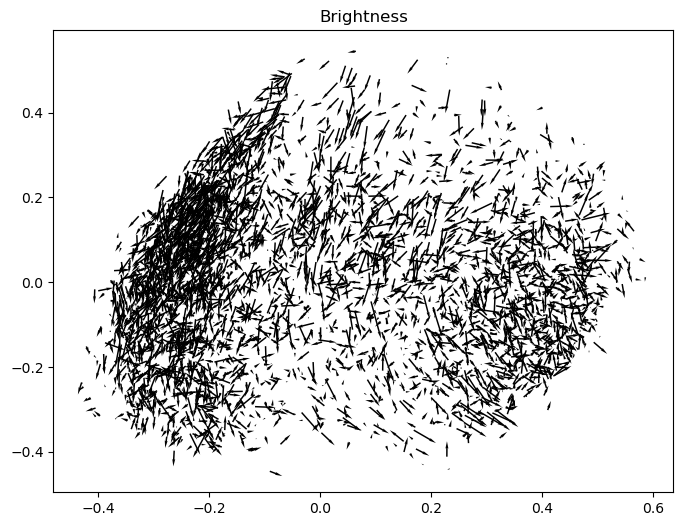

In [47]:
pca = PCA(n_components=2)
pca.fit(embs_pc)

t_embs_pc = pca.transform(embs_pc)
t_vf_pc = pca.transform(vf_pc)

f = plt.figure(figsize = (8,6))
plt.quiver(t_embs_pc[:,0],t_embs_pc[:,1],vf_pc[:,0],vf_pc[:,1], scale =2.8,headwidth = 2)
plt.title(features[idx_dim])